# 1. Lecture CSV

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.cluster import DBSCAN, KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

from PIL import Image

import wordcloud

In [2]:
# Permet d"afficher toute la largeur de chaque colonne
pd.set_option("display.max_colwidth", 200)

In [3]:
df_corpus = pd.read_csv("../datas/sample-data-clean.csv", index_col="id")
df_corpus.head()

,description,description_clean,description_nlp_ready
id,,,
1,"Active classic boxers - There's a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space ...",active classic boxers there s a reason why our boxers are a cult favorite they keep their cool especially in sticky situations the quick drying lightweight underwear takes up minimal space ...,active classic boxer s reason boxer cult favorite cool especially sticky situation quick dry lightweight underwear take minimal space travel pack expose brush waistband offer skin softness panel c...
2,Active sport boxer briefs - Skinning up Glory requires enough movement without your boxers deciding to poach their own route. The form-fitting Active Sport Boxer Briefs are made from breathable 93...,active sport boxer briefs skinning up glory requires enough movement without your boxers deciding to poach their own route the form fitting active sport boxer briefs are made from breathable ...,active sport boxer brief skin glory require movement boxer decide poach route form fit active sport boxer brief breathable recycle s fast wicke dry quickly spandex stretch seamless waistband soft ...
3,"Active sport briefs - These superbreathable no-fly briefs are the minimalist's choice for high-octane endeavors. Made from a blend of fast-wicking, quick-drying 93% polyester (71% recycled) and 7%...",active sport briefs these superbreathable no fly briefs are the minimalist s choice for high octane endeavors made from a blend of fast wicking quick drying polyester recycled and spand...,active sport brief superbreathable fly brief minimalist s choice high octane endeavor blend fast wicke quick dry recycle spandex stretch mesh support open mesh cool airflow soft edging leg opening...
4,"Alpine guide pants - Skin in, climb ice, switch to rock, traverse a knife-edge ridge and boogie back down - these durable, weather-resistant and breathable soft-shell pants keep stride on every mo...",alpine guide pants skin in climb ice switch to rock traverse a knife edge ridge and boogie back down these durable weather resistant and breathable soft shell pants keep stride on every mo...,alpine guide pant skin climb ice switch rock traverse knife edge ridge boogie durable weather resistant breathable soft shell pant stride mountain endeavor midweight stretch weave won t restrict m...
5,"Alpine wind jkt - On high ridges, steep ice and anything alpine, this jacket serves as a true ""best of all worlds"" staple. It excels as a stand-alone shell for blustery rock climbs, cool-weather t...",alpine wind jkt on high ridges steep ice and anything alpine this jacket serves as a true best of all worlds staple it excels as a stand alone shell for blustery rock climbs cool weather t...,alpine wind jkt high ridge steep ice alpine jacket serve true good world staple excel stand shell blustery rock climb cool weather trail run high output ski tour condition ice alpine climb functio...


---

# 2. Groupes d'articles avec des descriptions similaires

## 2.1 TF-IDF Matrix

In [4]:
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(df_corpus["description_nlp_ready"])

dense = X.toarray()
dense.shape

(500, 3515)

500 documents pour 3515 mots

## 2.2 Clustering avec DBSCAN

In [5]:
# Algo de test des paramètre de DBSCAN
def auto_tune_dbscan(X, eps_range, min_samples_range, metric):
    results = []

    for eps in eps_range:
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
            labels = dbscan.fit_predict(X)

            n_outliers = np.sum(labels == -1)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            outlier_ratio = round(n_outliers / len(labels), 3)

            results.append({
                "eps": eps,
                "min_samples": min_samples,
                "n_clusters": n_clusters,
                "n_outliers": n_outliers,
                "outlier_ratio": outlier_ratio
            })

    return pd.DataFrame(results)

In [6]:
# Je teste les paramètres
eps_vals = np.arange(0.15, 1, 0.01)
min_samples_vals = range(5, 40)

results_df = auto_tune_dbscan(X, eps_range=eps_vals, min_samples_range=min_samples_vals, metric="cosine")

In [7]:
# Filtre des résultats pour avoir le bon nombre de clusters (entre 10 et 20) et pas trop d'outliers
mask = ((results_df["n_clusters"] > 10) & (results_df["n_clusters"] <=20))
results_df_filtered = results_df[mask]
results_df_filtered = results_df_filtered.sort_values("outlier_ratio", ascending=True)
results_df_filtered.head(10)

,eps,min_samples,n_clusters,n_outliers,outlier_ratio
1960,0.71,5,14,51,0.102
1925,0.70,5,15,73,0.146
1961,0.71,6,12,76,0.152
1890,0.69,5,16,95,0.190
1926,0.70,6,13,96,0.192
1855,0.68,5,16,101,0.202
1891,0.69,6,16,114,0.228
1820,0.67,5,18,114,0.228
1927,0.70,7,11,122,0.244
1856,0.68,6,15,123,0.246


In [8]:
# On applique les paramètres les plus adaptés
dbscan = DBSCAN(eps=0.70, min_samples=5, metric="cosine")
labels = dbscan.fit_predict(X)

# On ajoute le numéro du cluster associé à chaque article dans le dataframe
df_corpus["cluster_dbscan"] = labels

In [9]:
df_corpus.head()

,description,description_clean,description_nlp_ready,cluster_dbscan
id,,,,
1,"Active classic boxers - There's a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space ...",active classic boxers there s a reason why our boxers are a cult favorite they keep their cool especially in sticky situations the quick drying lightweight underwear takes up minimal space ...,active classic boxer s reason boxer cult favorite cool especially sticky situation quick dry lightweight underwear take minimal space travel pack expose brush waistband offer skin softness panel c...,0
2,Active sport boxer briefs - Skinning up Glory requires enough movement without your boxers deciding to poach their own route. The form-fitting Active Sport Boxer Briefs are made from breathable 93...,active sport boxer briefs skinning up glory requires enough movement without your boxers deciding to poach their own route the form fitting active sport boxer briefs are made from breathable ...,active sport boxer brief skin glory require movement boxer decide poach route form fit active sport boxer brief breathable recycle s fast wicke dry quickly spandex stretch seamless waistband soft ...,0
3,"Active sport briefs - These superbreathable no-fly briefs are the minimalist's choice for high-octane endeavors. Made from a blend of fast-wicking, quick-drying 93% polyester (71% recycled) and 7%...",active sport briefs these superbreathable no fly briefs are the minimalist s choice for high octane endeavors made from a blend of fast wicking quick drying polyester recycled and spand...,active sport brief superbreathable fly brief minimalist s choice high octane endeavor blend fast wicke quick dry recycle spandex stretch mesh support open mesh cool airflow soft edging leg opening...,0
4,"Alpine guide pants - Skin in, climb ice, switch to rock, traverse a knife-edge ridge and boogie back down - these durable, weather-resistant and breathable soft-shell pants keep stride on every mo...",alpine guide pants skin in climb ice switch to rock traverse a knife edge ridge and boogie back down these durable weather resistant and breathable soft shell pants keep stride on every mo...,alpine guide pant skin climb ice switch rock traverse knife edge ridge boogie durable weather resistant breathable soft shell pant stride mountain endeavor midweight stretch weave won t restrict m...,1
5,"Alpine wind jkt - On high ridges, steep ice and anything alpine, this jacket serves as a true ""best of all worlds"" staple. It excels as a stand-alone shell for blustery rock climbs, cool-weather t...",alpine wind jkt on high ridges steep ice and anything alpine this jacket serves as a true best of all worlds staple it excels as a stand alone shell for blustery rock climbs cool weather t...,alpine wind jkt high ridge steep ice alpine jacket serve true good world staple excel stand shell blustery rock climb cool weather trail run high output ski tour condition ice alpine climb functio...,1


Wordcloud des Outliers

In [10]:
the_north_face_mask = np.array(Image.open("../utils/mountain.jpg"))
wd = wordcloud.WordCloud(background_color="white", contour_width=1, contour_color="steelblue", mask = the_north_face_mask)

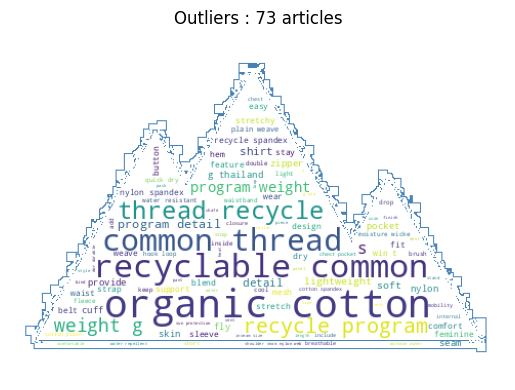

In [11]:
mask_outliers = (df_corpus["cluster_dbscan"] == -1)
products_cluster = df_corpus[mask_outliers]["description_nlp_ready"].tolist()
texte = " ".join(products_cluster)
cloud = wd.generate(texte)

plt.imshow(cloud)
plt.title(f"Outliers : {len(products_cluster)} articles")
plt.axis("off")
plt.show()

Wordcloud de chaque cluster

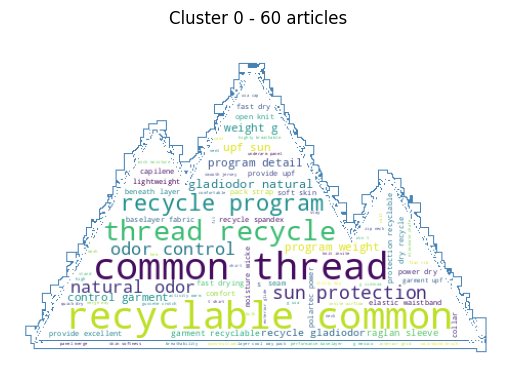

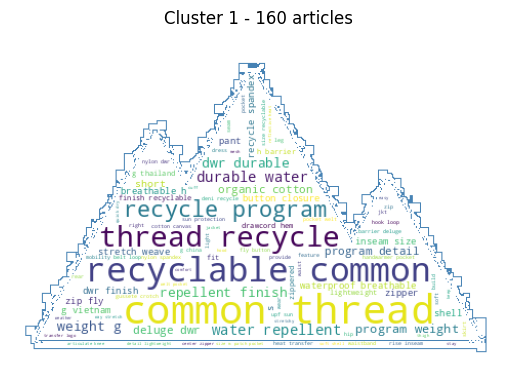

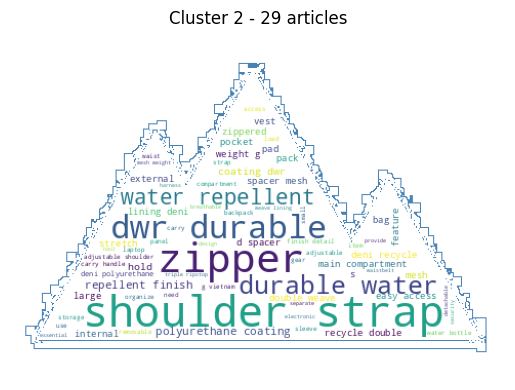

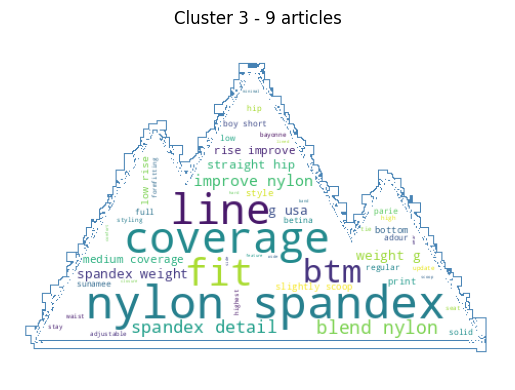

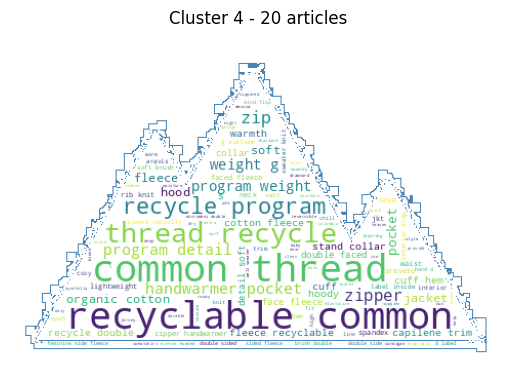

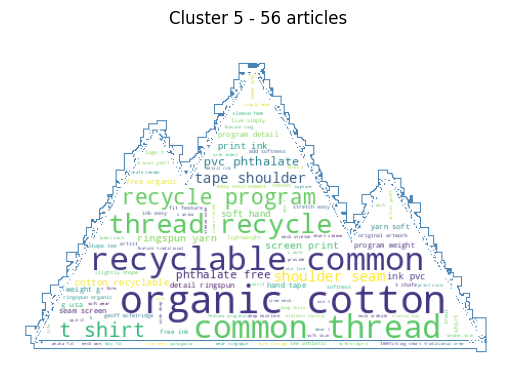

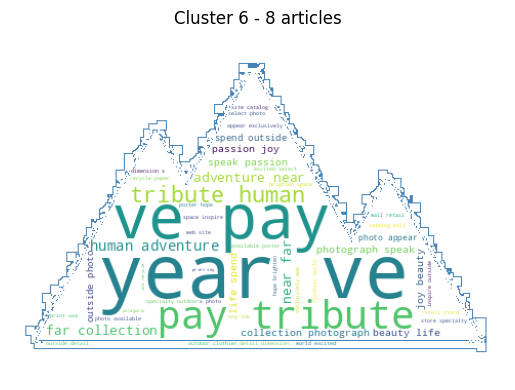

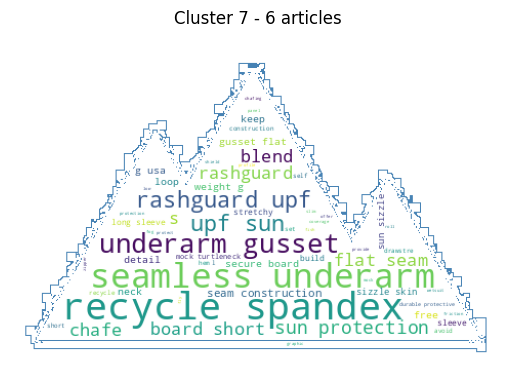

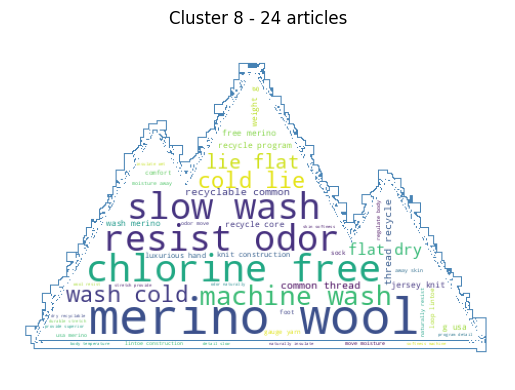

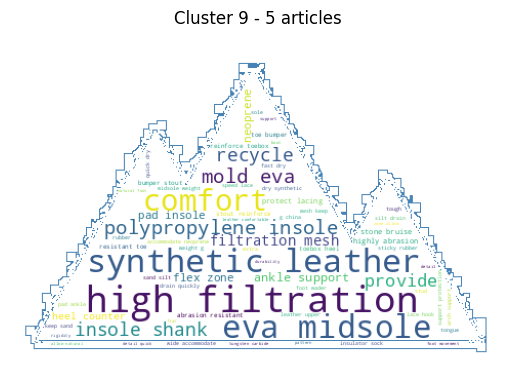

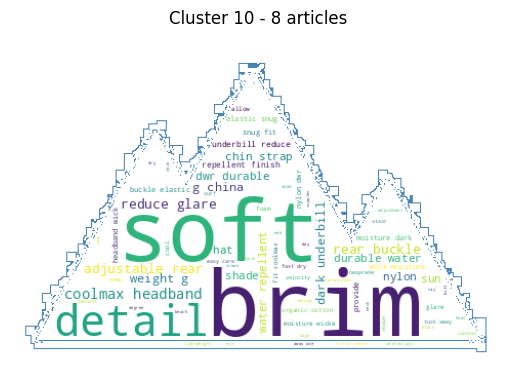

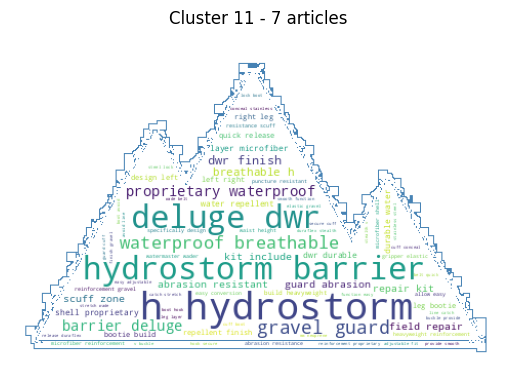

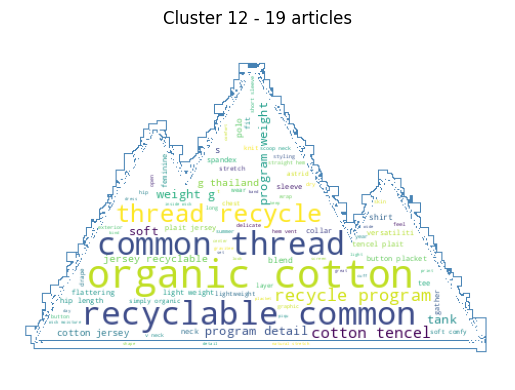

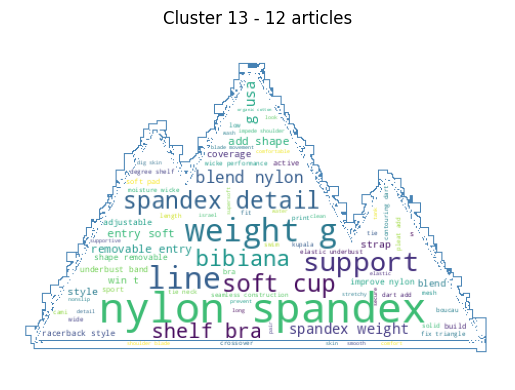

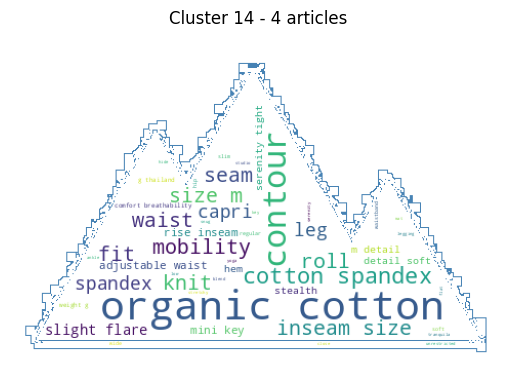

In [12]:
# Je veux un WordCloud par cluster
clusters = df_corpus[~mask_outliers]["cluster_dbscan"].unique()

for cluster_id in sorted(clusters):
    mask_cluster = (df_corpus["cluster_dbscan"] == cluster_id)
    products_cluster = df_corpus[mask_cluster]["description_nlp_ready"].tolist()
    texte = " ".join(products_cluster)
    cloud = wd.generate(texte)
    
    plt.imshow(cloud)
    plt.title(f"Cluster {cluster_id} - {len(products_cluster)} articles")
    plt.axis("off")
    plt.show()

In [13]:
df_corpus["cluster_dbscan"].value_counts().to_list()

[160, 73, 60, 56, 29, 24, 20, 19, 12, 9, 8, 8, 7, 6, 5, 4]

#### Conclusion Clustering DBSCAN :

Il m'a été assez difficile de trouver les bons paramètres DBSCAN pour obtenir une quinzaine de clusters, tout en limitant les outliers.

La distribution des clusters obtenus est déséquilibrée. Cette inégalité dans les tailles de clusters suggère que les données ne se prêtent peut-être pas bien à un regroupement par densité.

Je vais donc tester un clustering par KMeans, qui impose un nombre de clusters fixe et produit des clusters de taille généralement plus équilibrée. Cette méthode pourrait mieux correspondre à mon objectif de regrouper les descriptions en environ 15 catégories cohérentes.

---

## 2.3 Clustering avec KMeans

In [14]:
# On applique les paramètres les plus adaptés
kmeans = KMeans(n_clusters=15, random_state=42)
# On entraine KMeans sur X, car il s'agit déjà d'une matrice TF-IDF normalisée
labels = kmeans.fit_predict(X)

# On ajoute le numéro du cluster associé à chaque article dans le dataframe
df_corpus["cluster_kmeans"] = labels

In [15]:
df_corpus.head()

,description,description_clean,description_nlp_ready,cluster_dbscan,cluster_kmeans
id,,,,,
1,"Active classic boxers - There's a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space ...",active classic boxers there s a reason why our boxers are a cult favorite they keep their cool especially in sticky situations the quick drying lightweight underwear takes up minimal space ...,active classic boxer s reason boxer cult favorite cool especially sticky situation quick dry lightweight underwear take minimal space travel pack expose brush waistband offer skin softness panel c...,0,8
2,Active sport boxer briefs - Skinning up Glory requires enough movement without your boxers deciding to poach their own route. The form-fitting Active Sport Boxer Briefs are made from breathable 93...,active sport boxer briefs skinning up glory requires enough movement without your boxers deciding to poach their own route the form fitting active sport boxer briefs are made from breathable ...,active sport boxer brief skin glory require movement boxer decide poach route form fit active sport boxer brief breathable recycle s fast wicke dry quickly spandex stretch seamless waistband soft ...,0,6
3,"Active sport briefs - These superbreathable no-fly briefs are the minimalist's choice for high-octane endeavors. Made from a blend of fast-wicking, quick-drying 93% polyester (71% recycled) and 7%...",active sport briefs these superbreathable no fly briefs are the minimalist s choice for high octane endeavors made from a blend of fast wicking quick drying polyester recycled and spand...,active sport brief superbreathable fly brief minimalist s choice high octane endeavor blend fast wicke quick dry recycle spandex stretch mesh support open mesh cool airflow soft edging leg opening...,0,6
4,"Alpine guide pants - Skin in, climb ice, switch to rock, traverse a knife-edge ridge and boogie back down - these durable, weather-resistant and breathable soft-shell pants keep stride on every mo...",alpine guide pants skin in climb ice switch to rock traverse a knife edge ridge and boogie back down these durable weather resistant and breathable soft shell pants keep stride on every mo...,alpine guide pant skin climb ice switch rock traverse knife edge ridge boogie durable weather resistant breathable soft shell pant stride mountain endeavor midweight stretch weave won t restrict m...,1,0
5,"Alpine wind jkt - On high ridges, steep ice and anything alpine, this jacket serves as a true ""best of all worlds"" staple. It excels as a stand-alone shell for blustery rock climbs, cool-weather t...",alpine wind jkt on high ridges steep ice and anything alpine this jacket serves as a true best of all worlds staple it excels as a stand alone shell for blustery rock climbs cool weather t...,alpine wind jkt high ridge steep ice alpine jacket serve true good world staple excel stand shell blustery rock climb cool weather trail run high output ski tour condition ice alpine climb functio...,1,3


Wordcloud de chaque cluster

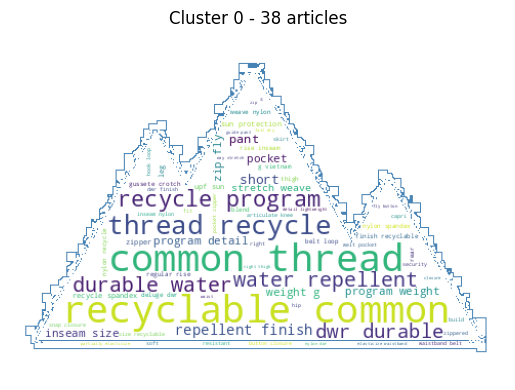

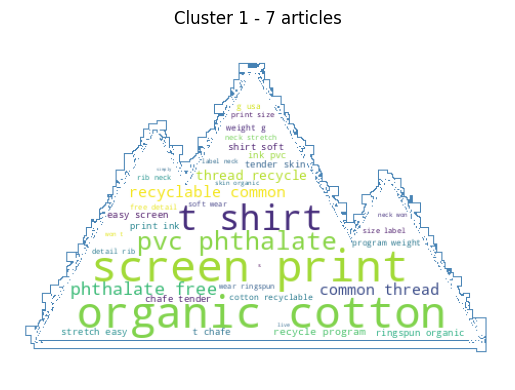

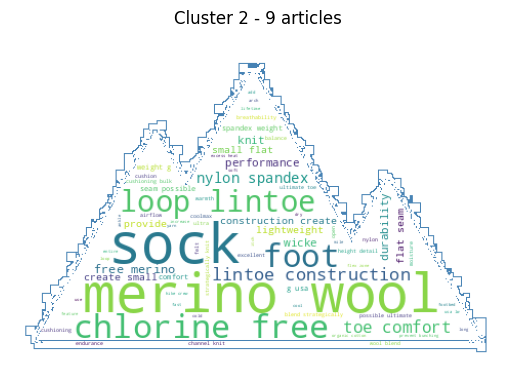

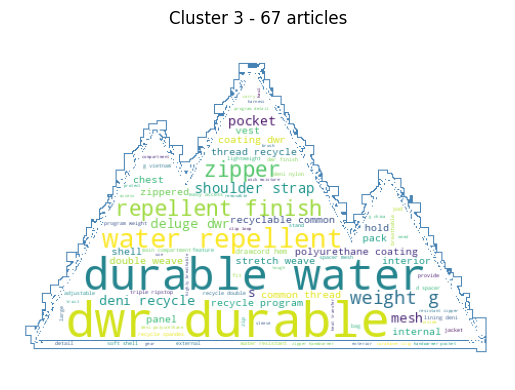

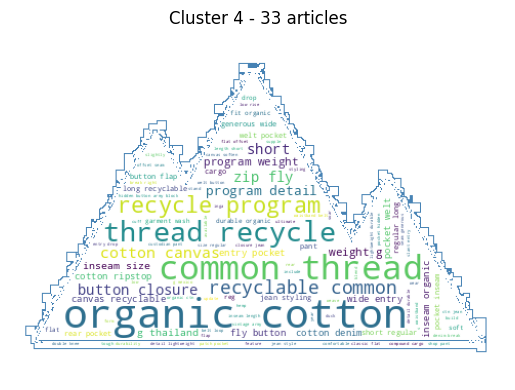

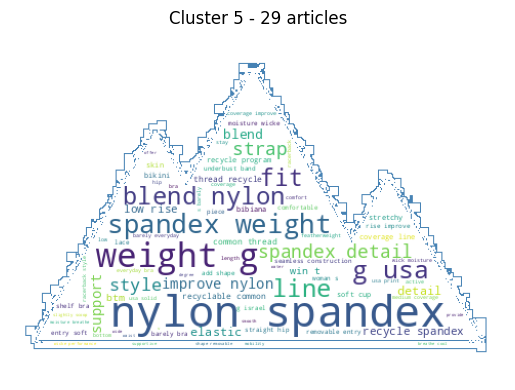

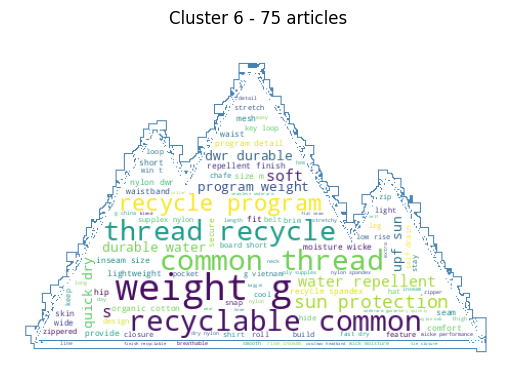

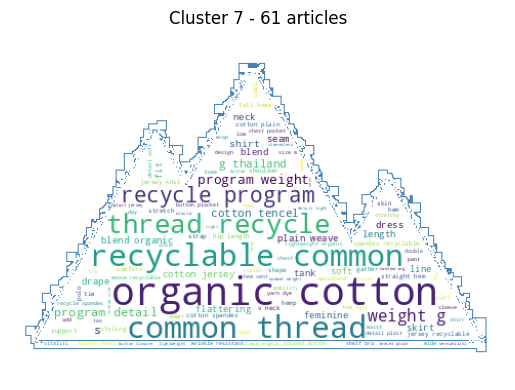

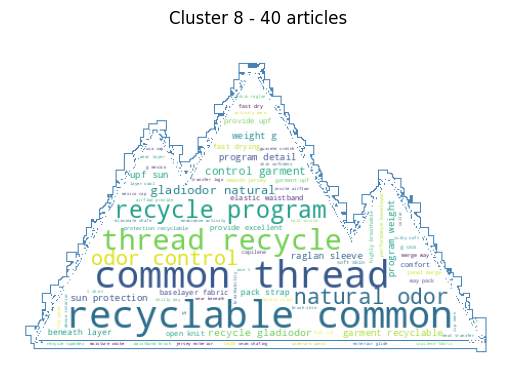

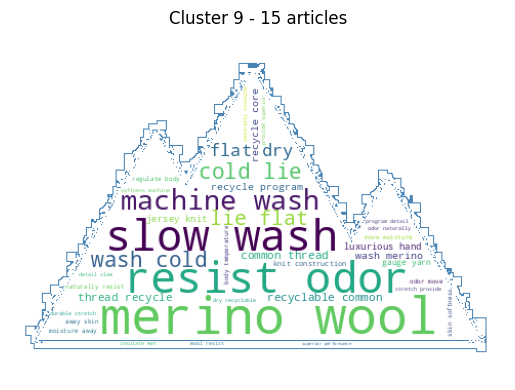

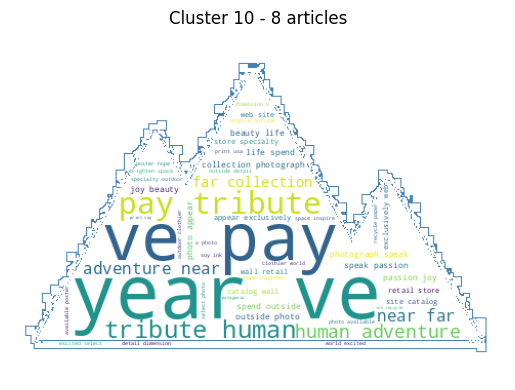

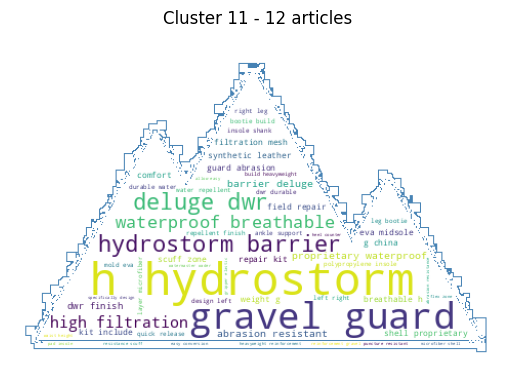

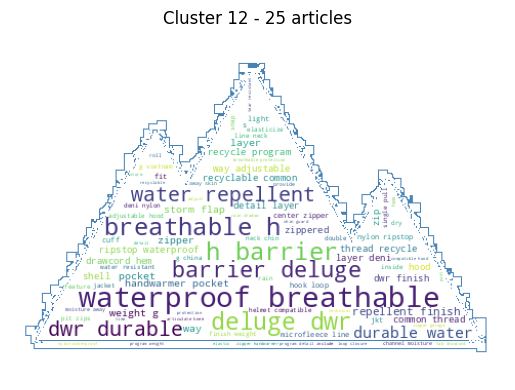

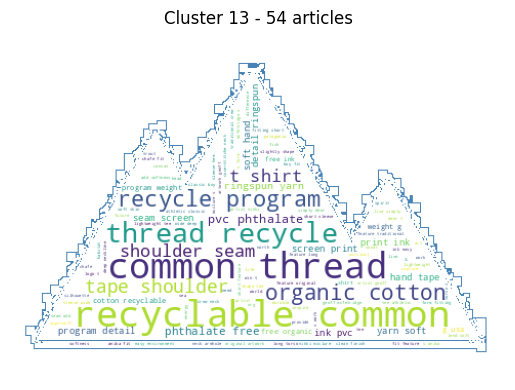

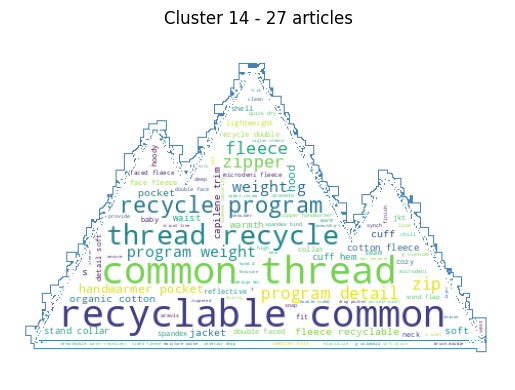

In [16]:
# Je veux un WordCloud par cluster
clusters = df_corpus[~mask_outliers]["cluster_kmeans"].unique()

for cluster_id in sorted(clusters):
    mask_cluster = (df_corpus["cluster_kmeans"] == cluster_id)
    products_cluster = df_corpus[mask_cluster]["description_nlp_ready"].tolist()
    texte = " ".join(products_cluster)
    cloud = wd.generate(texte)
    
    plt.imshow(cloud)
    plt.title(f"Cluster {cluster_id} - {len(products_cluster)} articles")
    plt.axis("off")
    plt.show()

In [17]:
df_corpus["cluster_dbscan"].value_counts().to_list()

[160, 73, 60, 56, 29, 24, 20, 19, 12, 9, 8, 8, 7, 6, 5, 4]

In [18]:
df_corpus["cluster_kmeans"].value_counts().to_list()

[75, 67, 61, 54, 40, 38, 33, 29, 27, 25, 15, 12, 9, 8, 7]

#### Conclusion CLustering Kmeans :

Le clustering avec KMeans permet d’obtenir des groupes d'articles plus homogène en termes de taille de clusters. 


Je vais donc conserver ce clustering

In [19]:
df_corpus = df_corpus.drop(columns=["cluster_dbscan"])
df_corpus = df_corpus.rename(columns={"cluster_kmeans": "cluster"})
df_corpus.head()

,description,description_clean,description_nlp_ready,cluster
id,,,,
1,"Active classic boxers - There's a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space ...",active classic boxers there s a reason why our boxers are a cult favorite they keep their cool especially in sticky situations the quick drying lightweight underwear takes up minimal space ...,active classic boxer s reason boxer cult favorite cool especially sticky situation quick dry lightweight underwear take minimal space travel pack expose brush waistband offer skin softness panel c...,8
2,Active sport boxer briefs - Skinning up Glory requires enough movement without your boxers deciding to poach their own route. The form-fitting Active Sport Boxer Briefs are made from breathable 93...,active sport boxer briefs skinning up glory requires enough movement without your boxers deciding to poach their own route the form fitting active sport boxer briefs are made from breathable ...,active sport boxer brief skin glory require movement boxer decide poach route form fit active sport boxer brief breathable recycle s fast wicke dry quickly spandex stretch seamless waistband soft ...,6
3,"Active sport briefs - These superbreathable no-fly briefs are the minimalist's choice for high-octane endeavors. Made from a blend of fast-wicking, quick-drying 93% polyester (71% recycled) and 7%...",active sport briefs these superbreathable no fly briefs are the minimalist s choice for high octane endeavors made from a blend of fast wicking quick drying polyester recycled and spand...,active sport brief superbreathable fly brief minimalist s choice high octane endeavor blend fast wicke quick dry recycle spandex stretch mesh support open mesh cool airflow soft edging leg opening...,6
4,"Alpine guide pants - Skin in, climb ice, switch to rock, traverse a knife-edge ridge and boogie back down - these durable, weather-resistant and breathable soft-shell pants keep stride on every mo...",alpine guide pants skin in climb ice switch to rock traverse a knife edge ridge and boogie back down these durable weather resistant and breathable soft shell pants keep stride on every mo...,alpine guide pant skin climb ice switch rock traverse knife edge ridge boogie durable weather resistant breathable soft shell pant stride mountain endeavor midweight stretch weave won t restrict m...,0
5,"Alpine wind jkt - On high ridges, steep ice and anything alpine, this jacket serves as a true ""best of all worlds"" staple. It excels as a stand-alone shell for blustery rock climbs, cool-weather t...",alpine wind jkt on high ridges steep ice and anything alpine this jacket serves as a true best of all worlds staple it excels as a stand alone shell for blustery rock climbs cool weather t...,alpine wind jkt high ridge steep ice alpine jacket serve true good world staple excel stand shell blustery rock climb cool weather trail run high output ski tour condition ice alpine climb functio...,3


---

Sauvegarde du fichier avec cluster

In [20]:
df_corpus.to_csv("../datas/sample-data-clean-clusters.csv")